<a href="https://colab.research.google.com/github/Snigdho64/Google_Collab_Notebooks/blob/main/Dog_Breed_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-end Multi-Class Dog-Breed Identification Classification
This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub



---
## 1. Problem Definition
Identifying a breed of a dog using an image 


---
## 2. Data
Data source :- https://www.kaggle.com/c/dog-breed-identification/data


---
## 3. Evaluation
* Submissions are evaluated on `Multi Class Log` Loss between the predicted probability and the observed target.
* For each image in the test set, you must predict a probability for each of the different breeds.
https://www.kaggle.com/c/dog-breed-identification/overview/evaluation
---
## 4. Feature 
* A training set and a test set of images of dogs.
* Each image has a filename that is its unique id.
* The dataset comprises 120 breeds of dogs. 


---
## 5. Goal
* The goal of the competition is to create a classifier capable of determining a dog's breed from a photo

---



---



In [ ]:
#unzip the data into our google-drive
!unzip "drive/MyDrive/Dog-Breed-Identification/dog-breed-identification.zip" -d "drive/MyDrive/Dog-Breed-Identification"

Archive:  drive/MyDrive/Dog-Breed-Identification/dog-breed-identification.zip
replace drive/MyDrive/Dog-Breed-Identification/labels.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Getting our workspace ready

In [ ]:
#import primary modules for deep learning
import tensorflow as tf
import tensorflow_hub as hub
#check version
print(f'''Tensorflow version :  {tf.__version__}
      \nTensorflow_hub version: {hub.__version__}''')

Tensorflow version :  2.7.0
      
Tensorflow_hub version: 0.12.0


In [ ]:
#Check for GPU availablity
print(f'GPU is','Available' if tf.config.list_physical_devices('GPU') else 'Not Available')

GPU is Not Available



# Getting our data ready
* First we look at our data (how it's structured) all the features and labels.
* Then we convert all our data into numeric format i.e. Tensors for our `Deep Learning Model`

In [ ]:
import pandas as pd
labels = pd.read_csv('drive/MyDrive/Dog-Breed-Identification/labels.csv')
labels.describe()

,id,breed
count,10222,10222
unique,10222,120
top,03bc1c631e57ba87c85b98efd0912c00,scottish_deerhound
freq,1,126


In [ ]:

labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


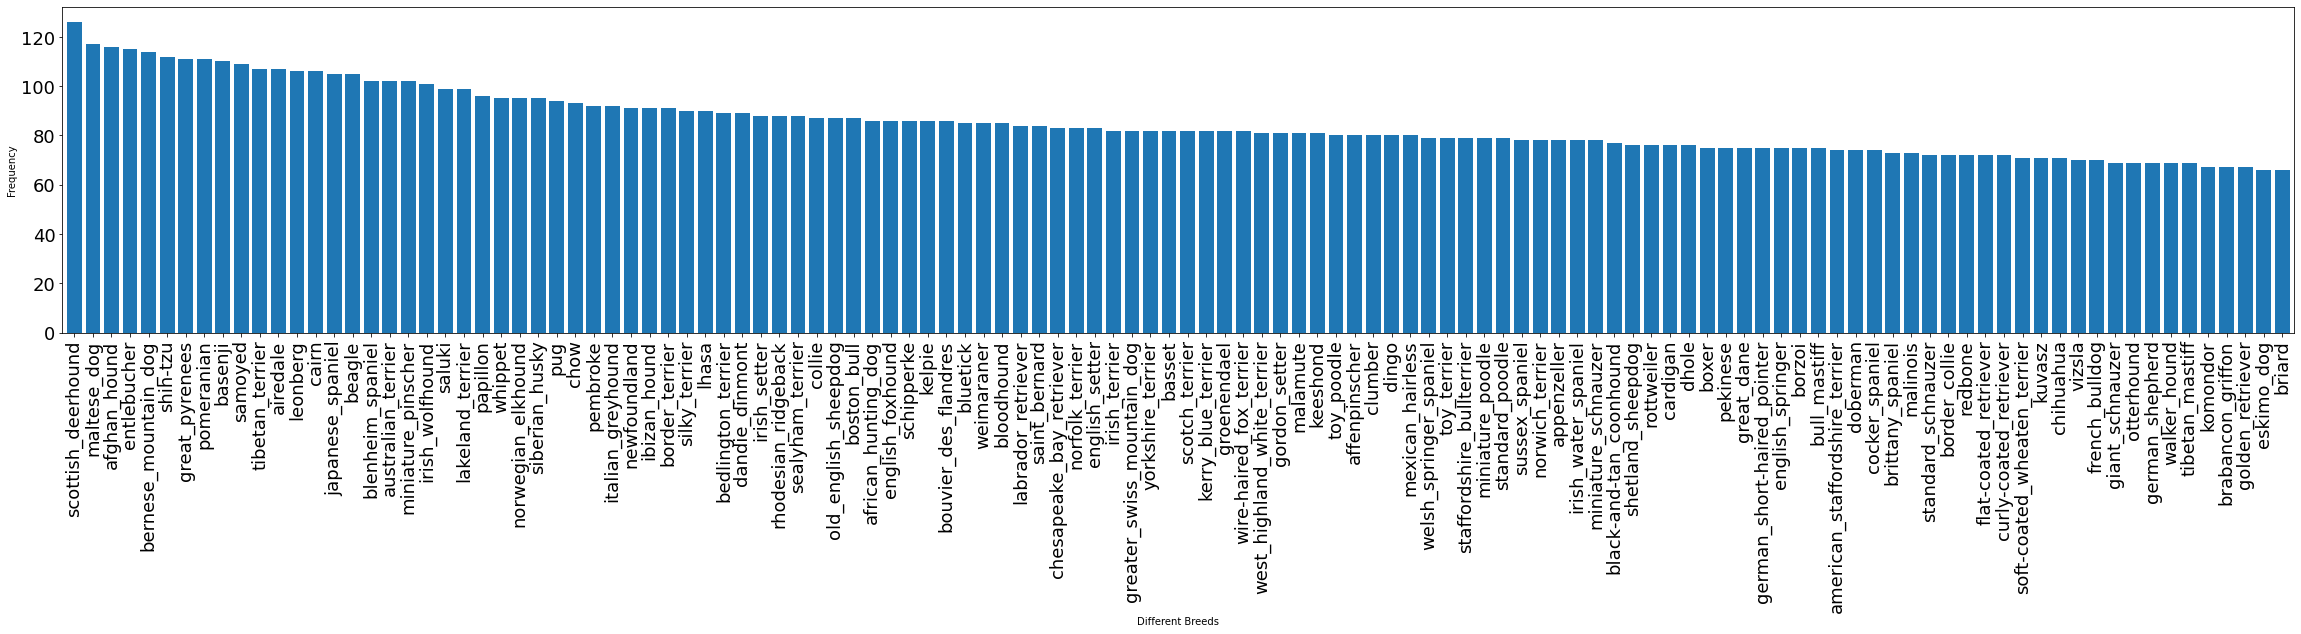

In [ ]:
labels['breed'].value_counts().plot(kind='bar',figsize=(40,6),xlabel='Different Breeds',ylabel='Frequency',fontsize=18,align='center',width=0.8)

In [ ]:
#median number per class
labels['breed'].value_counts().median()

82.0

## Create A List of all our Image Paths
* Our `label['id']` column represents the name of the file located in the train set
* We create a list of file paths from our label.id
* We verify if the number of files are equal to the number of values in the label.id

In [ ]:
#Create a file path for each label.id 
dog_images = [f'drive/MyDrive/Dog-Breed-Identification/train/{filename}.jpg' for filename in labels['id']]
dog_images[:10]

['drive/MyDrive/Dog-Breed-Identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog-Breed-Identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog-Breed-Identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog-Breed-Identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog-Breed-Identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog-Breed-Identification/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog-Breed-Identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog-Breed-Identification/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog-Breed-Identification/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog-Breed-Identification/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [ ]:
#Verify if number of images in Test data is equal to number of values in label.id
import os
len(os.listdir('drive/MyDrive/Dog-Breed-Identification/train')) == len(dog_images)

True

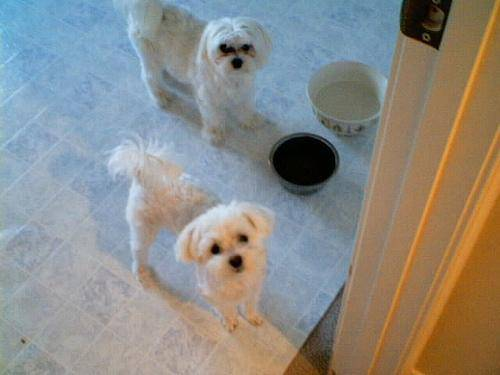

In [ ]:
#Check if file paths work correctly
from IPython.display import Image
Image(dog_images[90])

### Convert our `labels.breed` into a list of numeric type array
* Use numpy for conversion
* Convert `label.breed` to boolean array and to numeric int array

In [ ]:
#create a numpy array of the breed column of label
import numpy as np
breed_labels = np.array(labels['breed'])
breed_labels,len(breed_labels)

(array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
        'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object),
 10222)

In [ ]:
#create a numpy array of unique breeds
unique_breeds = np.unique(labels['breed'])
type(unique_breeds),len(unique_breeds)

(numpy.ndarray, 120)

In [ ]:
#create a boolean array representation for each dog_breed
boolean_breeds = [breed_label==unique_breeds for breed_label in breed_labels]
type(boolean_breeds),len(boolean_breeds)

(list, 10222)

In [ ]:
#convert each boolean label to array of ints (Encoding Similar to one-hot-encoder)
dog_breeds = [boolean_breed.astype(int) for boolean_breed in boolean_breeds]

### Spliting our train-data set into train and validation set
* We'll start with expeimenting with a size of 1000 datasets

In [ ]:
#Create X and y variables from our train data
X = dog_images
y = dog_breeds

#Creata a size limit range for our train dat
SIZE = 1000 #@param {type:"slider",min:"1000",max:"10222"}

#Split our data into train and validation set
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val = train_test_split(X[:SIZE],y[:SIZE],test_size=0.2,random_state=42)
len(X_train),len(y_val)

(800, 200)

## Preprocessing Images(turning images into Tensors)
Create a funtion for preprocessing image :-
1. Take an image path as an input
2. Use TensorFlow to read the file and save it to a variable
3. Turn our Images into Tensors (similar to numpy array)
4. Resize the image to be of shape (224,224)
5. Return the modfied shape

In [ ]:
#create a function for preprocessing image
def process_image(image_path,size=[224,224]):
  '''
  Takes an image(url) and turns it into a Tensor
  '''
  #Read an image file with tf
  image = tf.io.read_file(image_path)
  #Turn the jpeg image into numerical Tensor with 3 color channels (rgb)
  image = tf.image.decode_jpeg(image,channels=3)
  #Convert the color channel values from 0-255 to 0-1
  image = tf.image.convert_image_dtype(image,tf.float32)
  #Resize the image to desired value (224,224)
  image = tf.image.resize(image,size=size)
  return image

## Turning our data into batches
* Processing large amount of data with GPU will take a lot of memory
* So we distribute our data into batches and interate over the batches so as to prevent memory overloading
* Ideal batch size for images is 32 (Read docs)
*In order to use Tensors effectively we'll convert our data in Tuple pairs of Image and Label

In [ ]:
#Create a function for returning a Tuple pair of Tensors of our pre-processed data
def tf_image_label(image,label):
  '''
  Takes an image(url) and it's associated label
  Returns a tuple of image,label each of type tensor
  '''
  if not tf.is_tensor(label):
    label = tf.constant(label)
  return (process_image(image),label)

In [ ]:
tf_image_label(X[42],y[42])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

In [ ]:
#Function to turn our data into batches
def create_data_batches(X,y=None,batch_size=32,valid_data=False,test_data=False):
  '''
  Create batches our (image,label) tensor pairs
  Shuffle the data if it's training set else don't shuffle
  Also accepts test data as input no labels
  '''
  #if the data is test dataset from our,we don't have labels
  if test_data:
    print('Creating test data batches...')
    #create dataset
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    data_batch = data.map(process_image).batch(batch_size)
    return data_batch
  
  #if the data is valid set,we don't need to shuffle if
  elif valid_data:
    print('Creating validation data batches...')
    #create a dataset from our (image,label) tensor pair
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                              tf.constant(y)))
    data_batch = data.map(tf_image_label).batch(batch_size)
    return data_batch
  #if the data is training set,shuffle the data
  else:
    print('Creating train data batches...')
    #create a dataset from our (image,label) tensor pair
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
    #shuffle the training data
    data = data.shuffle(buffer_size=len(X))
    data_batch = data.map(tf_image_label).batch(batch_size)
    return data_batch



In [ ]:
#testing our create_batch functuion
train_data = create_data_batches(X_train,y_train)
val_data = create_data_batches(X_val,y_val,valid_data=True)

Creating train data batches...
Creating validation data batches...


In [ ]:
train_data.element_spec,val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.int32, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.int32, name=None)))

# Visualising our data
* Visulaise our data batches with matplot
* create a function to show the images with their labels

In [ ]:
#Create a function for visulaising our data batches
import matplotlib.pyplot as plt

def show_25_images(images,labels):
  '''
  Displays a plot of 25 images and their labels nfrom our data batches
  '''
  #setup the figure
  fig,ax = plt.subplots(nrows=5,ncols=5,sharex=True,sharey=True,squeeze=False,figsize=(15,10))
  for i in range(25):
    #create subplot for each image
    plt.subplot(5,5,i+1)
    #display the image
    plt.imshow(images[i])
    #add image label as title
    plt.title(unique_breeds[labels[i].argmax()])
    #turn off grid-lines
    plt.axis('off')

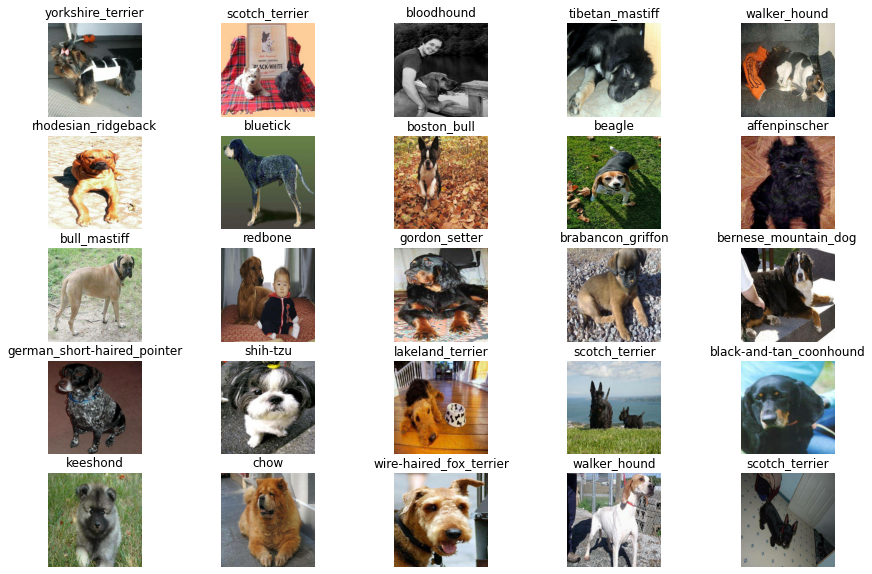

In [ ]:
train_images,train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images,train_labels)

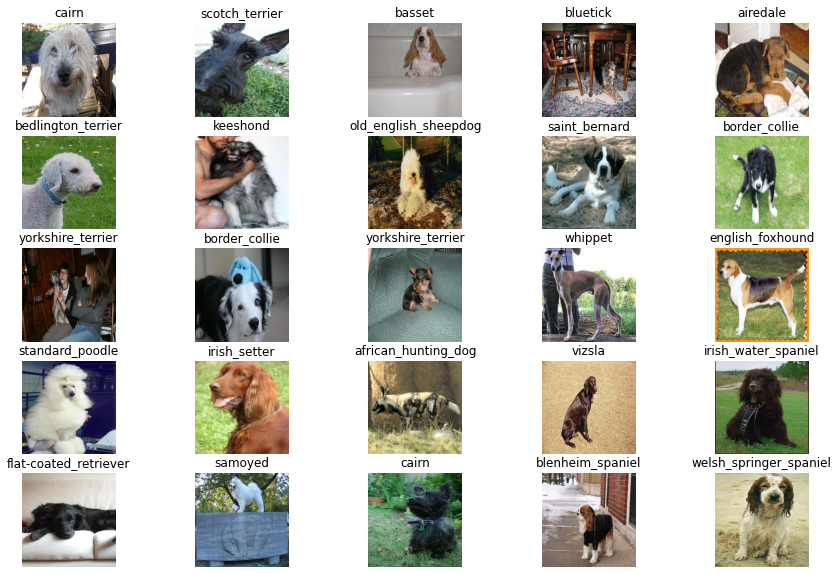

In [ ]:
val_images,val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images,val_labels)

# Building Our Model
Before we build our model, we have to define :
1. The input shape (our image shape, in the form of Tensors) to our model.
2. The output shape (image labels, in the form of Tensors) of ou model.
3. The URL of the model we want to use
  * From Tensorflow hub - https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/5

In [ ]:
#input shape of our model
INPUT_SHAPE = [None,224,224,3] #batch,height,width,channels

#output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

#setup model URL from TensorFlow Hub
MODEL_URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4'

Using **Keras** Deep Learning Model
Create a function that ▶
* Takes the input shape,output shape and the model we've choosen as parameters
* Defines the layers in a Keras model in sequential fashion
* Complies the model
* Builds the model
* Returns the model

In [ ]:
#create a function which builds a Keras Model
def create_model(input_shape=INPUT_SHAPE,output_Shape=OUTPUT_SHAPE,model=MODEL_URL):
  print('Building model with :',model)

  #setup model layers
  model = tf.keras.Sequential([
                               hub.KerasLayer(MODEL_URL), #layer 1 (input layer)
                               tf.keras.layers.Dense(units=OUTPUT_SHAPE,activation='softmax') #layer 2 (output layer)
                               ])
  #compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=['accuracy'])
  
  #Build the model
  model.build(input_shape)

  return model

In [ ]:
model = create_model()
model.summary()


Building model with : https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating Callbacks
`Callbacks` are helper function a model can use during training to do such things as save it's progress, check it's progress or stop training early if a model stops improving.
We'll create two callbacks, one for  `TensorBoard` which helps track our models progress and another for early stopping which prevents our model from training for too long.


### TensorBoard Callback
To set-up TensorBoard callback, we need to do 3 things:
1. Load the TensorFlow notebook extension
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit` function.
3. Visualize our model's training logs with our `%tensorboard` maagic function

In [ ]:
#Load TensorBoard notebook extension
%load_ext tensorboard

import datetime

#create a function to build a TensorFlow callback
def create_tensorboard_callback():
  #create a log directory for storing TensorFlow logs
  logdir = os.path.join('drive/MyDrive/Dog-Breed-Identification/logs',
                        #Filename should be trackable when we run our experiment
                        datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
                        )
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback
Prevents the model from over-fitting by stopping the model to further train on our training data when our model stops improving


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3)

# Training A Model (on a subset of data)
Our first model will be trained on 1000 image, to make sure everything is working

In [ ]:
NUM_EPOCH = 100 #@param {type:'slider',min:10,max:100,step:10}

### Create a function which trains model:-
* Create a model using `create_model()`
* Setup TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit` function on our model passing it the training data, validation data, number of epochs to train for and the callbacks we'd like to use
* Return the model

In [ ]:
#Build a function to train a model
def train_model():
  '''
  Train a model with our data-sets and return the trained model
  '''
  #Create a model
  model= create_model()

  #Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  #Fit the model to our train and validation data pasin it the callbacks w e created
  model.fit(x=train_data,
            epochs=NUM_EPOCH,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard,early_stopping])

  #Return the fitted model
  return model

In [ ]:
#Fit the model to our data
model = train_model()

Building model with : https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 300s 12s/step - loss: 4.6188 - accuracy: 0.1075 - val_loss: 3.5271 - val_accuracy: 0.2650
Epoch 2/100
25/25 [==============================] - 5s 186ms/step - loss: 1.6687 - accuracy: 0.6700 - val_loss: 2.2238 - val_accuracy: 0.4950
Epoch 3/100
25/25 [==============================] - 5s 191ms/step - loss: 0.5789 - accuracy: 0.9350 - val_loss: 1.7485 - val_accuracy: 0.5750
Epoch 4/100
25/25 [==============================] - 5s 191ms/step - loss: 0.2552 - accuracy: 0.9900 - val_loss: 1.5609 - val_accuracy: 0.6200
Epoch 5/100
25/25 [==============================] - 5s 182ms/step - loss: 0.1457 - accuracy: 0.9987 - val_loss: 1.4720 - val_accuracy: 0.6400
Epoch 6/100
25/25 [==============================] - 5s 182ms/step - loss: 0.1009 - accuracy: 1.0000 - val_loss: 1.4205 - val_accuracy: 0.6450
Epoch 7/100
25/25 [=============================

* Our Model is over-fitting because our accuracy on Training data is 1 (perfect) but accuracy is not so good on our val_data



### Checking the TensorFlowLogs
* The TensorFlow `%tensorflow` will access the logs directory we created earlier and visualise its contents

In [ ]:
%tensorboard --logdir drive/MyDrive/Dog-Breed-Identification/logs

# Making Predictions and evaluations on our validation data
* we'll use our `model.predict()` on our valid_data
* Returns a array of shape (200,120)
200 = size of val data
120 = no of category labels(do_breeds)
* Each 200 element conatains an array of 120 sub elements of number b/w 0-1 representing the probability of the label being that category

In [ ]:
predictions = model.predict(val_data,verbose=1)
predictions

In [ ]:
np.shape(predictions),np.sum(predictions[0]),np.sum(predictions[54])

### Creat a Function that returns our category label(do_breed) for each of predictions

In [ ]:
def get_pred_labels(pred_probs=predictions):
  '''
  Takes a prediction probability array and returns a array of labels
  for each of our predictions
  '''
  #create an empty array for labels
  pred_labels = []

  #loop through each prediction 
  for i in range(len(pred_probs)):
    label = unique_breeds[np.argmax(pred_probs[i])]
    pred_labels.append(label)

  return pred_labels

NameError: ignored

In [ ]:
pred_labels = get_pred_labels()
pred_labels[199]

### Create a function to `unbatch` our val_data into images and labels

In [ ]:
def unbatch_data(data=val_data):
  '''
  Takes a batched dataset of (images,labels) Tensor pair and seperates them into array of images and labels
  '''
  images = []
  labels= []

  #loop through unbatch data
  for image,label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(label)

  return images,labels

In [ ]:
val_images,val_labels = unbatch_data(val_data)
val_images[0],val_labels[0]

# Create a Visualisation for comparinng our predicted labels with val labels(true label)


In [ ]:
def show_image_pred(pred_probs=predictions,val_data=[val_images,val_labels],i=1):
  '''
  Show the True Image along with label The shows the predicted label and true label
  '''
  pred_prob,val_label,val_image = predictions[i],val_labels[i],val_images[i]
  
  pred_label = unique_breeds[np.argmax(pred_prob)]
  true_label = unique_breeds[np.argmax(val_label)]
  if pred_label == true_label:
    color='green'
  else:
    color='red'
  # plt.figure(figsize=(5,5))
  plt.imshow(val_images[i],aspect='auto', extent=(-2,4,-2,4))
  plt.xticks([])
  plt.yticks([])
  # plt.title('Predicting the dog breed from the image',fontsize=24,)
  plt.title(f'Actual Breed : {true_label}\nPredicted: {pred_label}\nAccuracy:{np.max(pred_prob)*100:2.0f}%',color=color,fontsize=20)

#call the image_predictor function
show_image_pred(i=77)


In [ ]:
unique_breeds[np.argmax(val_labels[3])],pred_labels[3]

# Plotting our models top 10 pedictions

In [ ]:
#create a function for plotting our top 10 probabilites
def plot_pred_top10(pred_probs=predictions,labels=val_labels,i=1):
  '''
  Plots a bar-plot of our top-10 predictions (out of 120 category)
  for the given validation label at index n
  '''
  #Extract the required prediction probability and validation label
  pred_prob,val_label = pred_probs[i],labels[i]

  #Find the predicted label and true label
  pred_label = unique_breeds[np.argmax(pred_prob)]
  true_label = unique_breeds[np.argmax(val_label)]
  
  #Get the top 10 indexs from of pre_prob array
  top_10_pred_indexs = pred_prob.argsort()[-10:][::-1]

  #Get the top 10 pobability values from our pred_prob array
  top_10_pred_values = pred_prob[top_10_pred_indexs]

  #Get the top 10 predicted labels for the given true_label
  top_10_pred_labels = unique_breeds[top_10_pred_indexs]

  #Plot the top 10 probability preditions
  # plt.figure(figsize=(12,6))

  top_10_plot = plt.bar(np.arange(10),top_10_pred_values,width=0.8,color='grey')

  plt.xticks(np.arange(10),labels=top_10_pred_labels,fontsize=18,rotation='vertical')

  #Change color of true label
  if np.isin(true_label,top_10_pred_labels):
    top_10_plot[np.argmax(top_10_pred_labels==true_label)].set_color('green')
  else:
    pass

In [ ]:
plot_pred_top10(i=24)

# Visualise Our Top 10 predictions

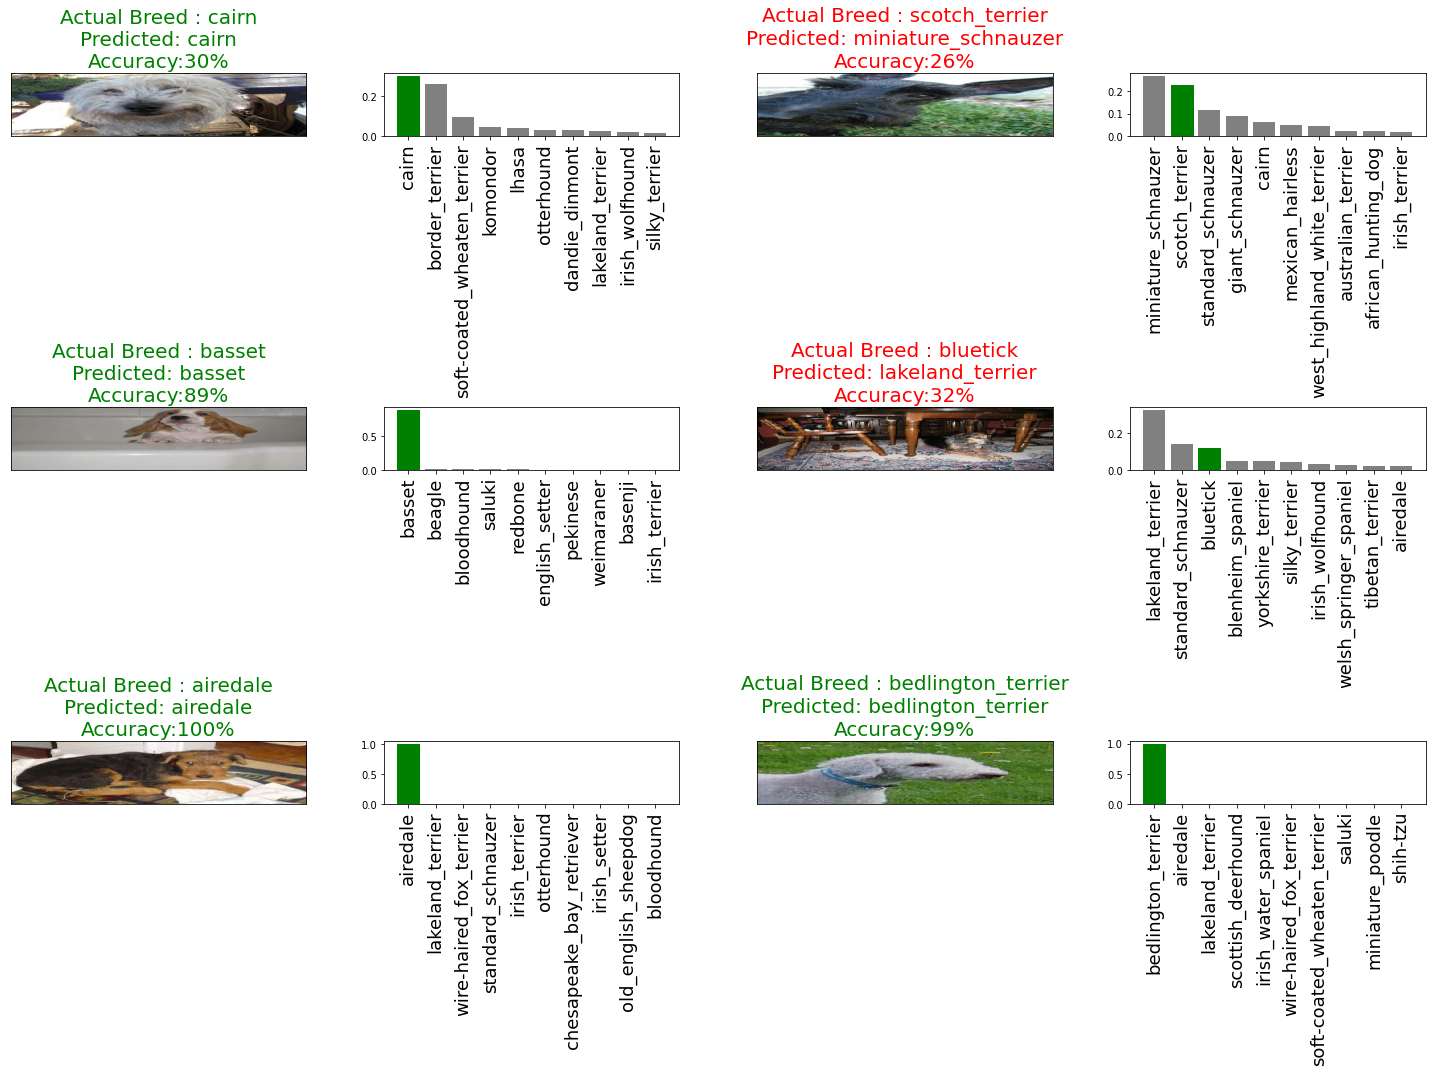

In [ ]:
#looping through 10 images per plot
i_multiplier = 0
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols,5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows,5*num_cols,2*i+1)
  show_image_pred(i=i+i_multiplier)
  plt.subplot(num_rows,2*num_cols,2*i+2)
  plot_pred_top10(i=i+i_multiplier)  
plt.tight_layout(h_pad=1.0)
plt.show()

# Saving And Reloading A Model

In [ ]:
#Create a funtion to save
def save_model(model,suffix=None):
  '''
  Saves a given model in models director and appends a suffix to filename
  '''
  #Create a model directory pathname with current time
  model_dir = os.path.join('drive/MyDrive/Dog-Breed-Identification/models',datetime.date.now().strftime('%Y%m%d-%H%M%s'))
  #append suffix to filename and add extension for model
  model_path = model_dir + '-' + suffix +'.h5'
  print(f'Saving Model...: {model_path}')
  #save the model
  model.save(model_path)


#Create a function to reload a model
def load_model(model_path):
  '''
  Loads a saved model given the path of the model
  '''
  print(f'Loading saved model... :{model_path}')
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={'KerasLayer':hub.KerasLayer})
  return model

In [ ]:
#save a Model
save_model(model,"dog-breed-classification")

NameError: ignored

In [ ]:
#load the saved model
dog_breed_model = load_model("drive/MyDrive/Dog-Breed-Identification/models/20211126-13541637934883-dog-breed-classification.h5")

Loading saved model... :drive/MyDrive/Dog-Breed-Identification/models/20211126-13541637934883-dog-breed-classification.h5


In [ ]:
#Evaluate the pre-saved model
model.evaluate(val_data)

NameError: ignored

In [ ]:
#Evaluate the loaded_model
dog_breed_model.evaluate(val_data)

7/7 [==============================] - 35s 4s/step - loss: 1.1985 - accuracy: 0.6850


[1.1985493898391724, 0.6850000023841858]

# Training Our Model on Full-Dataset

In [ ]:
#Create a data batch with full-dataset
full_data = create_data_batches(X,y)
full_data

Creating train data batches...


<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.int32)>

In [ ]:
#Create a model to train our full data
full_model = create_model()

Building model with : https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [ ]:
#create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
#No validation set when training on full dataset, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy',patience=3)

In [ ]:
full_model.fit(x=full_data,verbose=1,callbacks=[full_model_tensorboard,full_model_early_stopping],epochs=NUM_EPOCH)

Epoch 1/100
320/320 [==============================] - 1666s 5s/step - loss: 1.3327 - accuracy: 0.6694
Epoch 2/100
199/320 [=================>............] - ETA: 2:32 - loss: 0.3901 - accuracy: 0.8847

KeyboardInterrupt: ignored

In [ ]:
#Save the fully trained model
save_model(full_model,'trained-model-fulldata-mobilenetv2')

In [ ]:
#Load the fully trained model
loaded_full_model = load_model('drive/MyDrive/Dog-Breed-Identification/models/20211126-14491637938197-fully-trained-dog-breed-model.h5')

Loading saved model... :drive/MyDrive/Dog-Breed-Identification/models/20211126-14491637938197-fully-trained-dog-breed-model.h5


# Making predictions on the test dataset

Since our model has been trained on images in the form of Tensor batches, to make predictions on the test data, we'll have to get it into the same format.

Luckily we created `create_data_batches()` earlier which can take a list of filenames as input and conver them into Tensor batches.

To make predictions on the test data, we'll:

* Get the test image filenames. ✅
* Convert the filenames into test data batches using `create_data_batches()` and setting the test_data parameter to True (since the test data doesn't have labels). ✅
* Make a predictions array by passing the test batches to the `predict()` method called on our model.

In [ ]:
#Load test images filenames and create a list of the file names
test_path = 'drive/MyDrive/Dog-Breed-Identification/test/'

test_filenames = [test_path + fname for fname in os.listdir(test_path)]

test_filenames[:10]

['drive/MyDrive/Dog-Breed-Identification/test/e2f94ad185a2cfa2311c66c3e8bdba17.jpg',
 'drive/MyDrive/Dog-Breed-Identification/test/e278b2f68fa5d146e0bf06eee5faa0e3.jpg',
 'drive/MyDrive/Dog-Breed-Identification/test/e7be7b911a4cba9fdfa4105ec4776370.jpg',
 'drive/MyDrive/Dog-Breed-Identification/test/dd5c5652d5d34e922af98c9b0295d909.jpg',
 'drive/MyDrive/Dog-Breed-Identification/test/e2caef2df1087702936298aaac7843a1.jpg',
 'drive/MyDrive/Dog-Breed-Identification/test/e18c30f7ba3680d75ff326ccb71642e0.jpg',
 'drive/MyDrive/Dog-Breed-Identification/test/e1a777d181483b0982732fa4128df7f8.jpg',
 'drive/MyDrive/Dog-Breed-Identification/test/e6b1859592468c8ffc1a73f87b201ba7.jpg',
 'drive/MyDrive/Dog-Breed-Identification/test/dd703c7beeaf5cba5533d5f42b608f2e.jpg',
 'drive/MyDrive/Dog-Breed-Identification/test/df2d806debebfd39e858f877756518e8.jpg']

In [ ]:
#Create test data batch
test_data = create_data_batches(test_filenames,test_data=True)
test_data

Creating test data batches...


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

**Note**: Calling `predict()` on our full model and passing it the test data batch will take a long time to run (about a ~1hr). This is because we have to process ~10,000+ images and get our model to find patterns in those images and generate predictions based on what its learned in the training dataset.

In [ ]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

  5/324 [..............................] - ETA: 29:29

KeyboardInterrupt: ignored

In [ ]:
test_predicttions[:10],test_predictions.shape

# Preparing test dataset predictions for Kaggle
Looking at the Kaggle sample submission, we find that it wants our models prediction probaiblity outputs in a DataFrame with an ID and a column for each different dog breed. https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

To get the data in this format, we'll:

* Create a pandas DataFrame with an ID column as well as a column for each dog breed. ✅
* Add data to the ID column by extracting the test image ID's from their filepaths.
* Add data (the prediction probabilites) to each of the dog breed columns.
* Export the DataFrame as a CSV to submit it to Kaggle.

In [ ]:
#create a Pandas Dataframe
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

In [ ]:
# Append test image ID's to predictions DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"] = test_ids

In [ ]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

In [ ]:
# Save our predictions dataframe to CSV for submission to Kaggle
preds_df.to_csv("drive/My Drive/Dog Vision/full_model_predictions_submission_1_mobilenetV2.csv",
                index=False)

# Save our predictions dataframe to CSV for submission to Kaggle
preds_df.to_csv("drive/My Drive/Dog Vision/full_model_predictions_submission_1_mobilenetV2.csv",
                index=False)
Making predictions on custom images
To make predictions on custom images, we'll:

* Get the filepaths of our own images.
* Turn the filepaths into data batches using create_data_batches(). And since our custom images won't have labels, we set the test_data parameter to True.
* Pass the custom image data batch to our model's predict() method.
* Convert the prediction output probabilities to predictions labels.
* Compare the predicted labels to the custom images.

In [ ]:
import re
# Get custom image filepaths
custom_path = "drive/MyDrive/Dog-Breed-Identification/Cutom-Dog-Photos/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path) if '[]']
custom_image_paths

['drive/MyDrive/Dog-Breed-Identification/Cutom-Dog-Photos/.ipynb_checkpoints',
 'drive/MyDrive/Dog-Breed-Identification/Cutom-Dog-Photos/Dog-Type-3.jpg',
 'drive/MyDrive/Dog-Breed-Identification/Cutom-Dog-Photos/Dog-Type-2.jpg',
 'drive/MyDrive/Dog-Breed-Identification/Cutom-Dog-Photos/Dog-Type-1.jpg']

In [ ]:
# Turn custom images into batch datasets 
custom_data = create_data_batches(custom_image_paths, test_data=True)
custom_data

Creating test data batches...


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [ ]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)
custom_preds.shape

FailedPreconditionError: ignored

In [ ]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels


In [ ]:
# Get custom images (our unbatchify() function won't work since there aren't labels... maybe we could fix this later)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

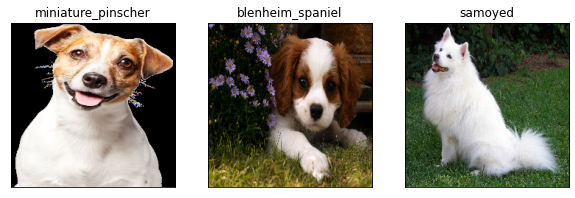

In [ ]:
# Check custom image predictions
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)